<a href="https://colab.research.google.com/github/xhxuciedu/cs273p/blob/main/convolutional_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Check GPU availability

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Hyper parameters

In [3]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

### Traing and test data

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print('Train data: ', train_dataset.train_data.shape)
print('Test data: ', test_dataset.test_data.shape)

Train data:  torch.Size([60000, 28, 28])
Test data:  torch.Size([10000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


### Check data

In [16]:
x, y = next(iter(train_loader))

In [17]:
# check the size of mini-batch
x.shape, y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

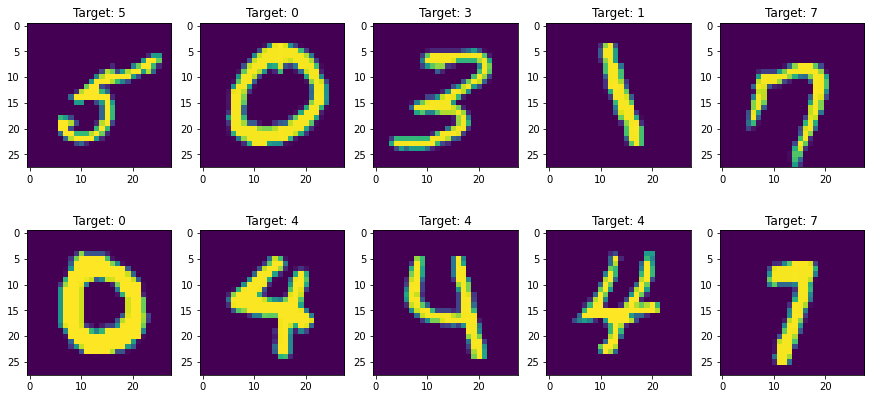

In [18]:
# plot a few samples
fig, ax = plt.subplots(2,5, figsize=(15,7))
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(x[i*5+j,0,:,:])
    ax[i,j].set_title('Target: {}'.format(y[i*5+j]))

### Defining the model

In [9]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


### Check parameters of the model

In [11]:
print(model.layer1.parameters)

<bound method Module.parameters of Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [12]:
# Check the convolution parameters
list(model.layer1.parameters())[0].shape

torch.Size([16, 1, 5, 5])

### Training

In [13]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.2285
Epoch [1/5], Step [200/600], Loss: 0.1469
Epoch [1/5], Step [300/600], Loss: 0.0966
Epoch [1/5], Step [400/600], Loss: 0.0998
Epoch [1/5], Step [500/600], Loss: 0.0317
Epoch [1/5], Step [600/600], Loss: 0.0888
Epoch [2/5], Step [100/600], Loss: 0.0318
Epoch [2/5], Step [200/600], Loss: 0.1540
Epoch [2/5], Step [300/600], Loss: 0.0455
Epoch [2/5], Step [400/600], Loss: 0.0305
Epoch [2/5], Step [500/600], Loss: 0.1291
Epoch [2/5], Step [600/600], Loss: 0.0224
Epoch [3/5], Step [100/600], Loss: 0.0197
Epoch [3/5], Step [200/600], Loss: 0.0468
Epoch [3/5], Step [300/600], Loss: 0.0197
Epoch [3/5], Step [400/600], Loss: 0.0055
Epoch [3/5], Step [500/600], Loss: 0.0327
Epoch [3/5], Step [600/600], Loss: 0.0071
Epoch [4/5], Step [100/600], Loss: 0.0641
Epoch [4/5], Step [200/600], Loss: 0.0149
Epoch [4/5], Step [300/600], Loss: 0.0596
Epoch [4/5], Step [400/600], Loss: 0.0085
Epoch [4/5], Step [500/600], Loss: 0.0935
Epoch [4/5], Step [600/600], Loss:

### Testing

In [14]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 98.19 %


In [15]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')